<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:black;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    <h2 style="color:white;"><center><i>The xP Philosophy</i></center></h2>
<h2 style="color:white;"><center>By: Fabrice Mulumba, Ramy Yousuf, and Fahad Ashraf</center></h2>
<h3 style="color:white;"><center><i>Metric Track</i</center></h3>

</p>
</div>

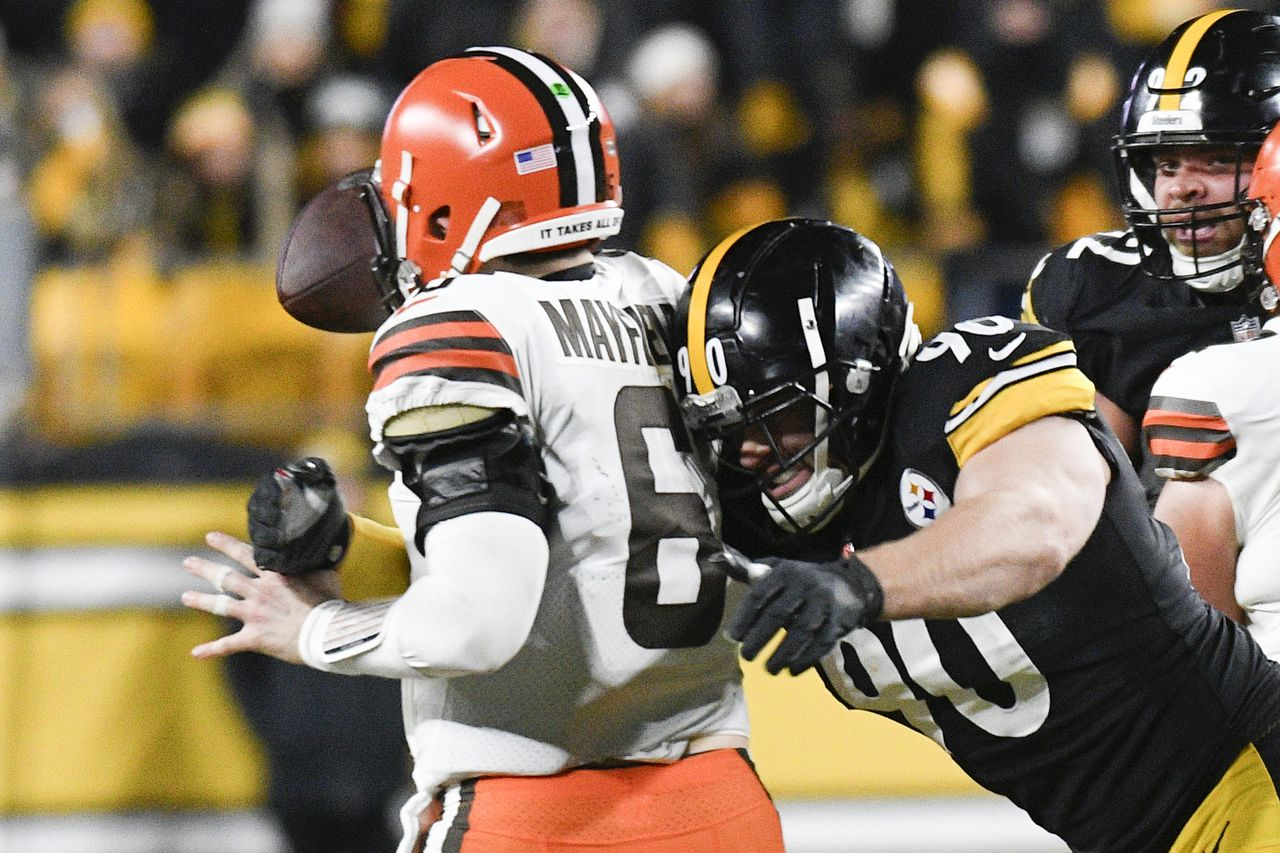

# <center>Introduction</center>

The Big Data Bowl this year is focused on offensive and defensive lineman data. We are focused on the Metric track: *Create a metric to assess performance and/or strategy. This can be focused on offensive or defensive players, and on teams or individuals.*
<br>
<br>
We will create an expected pressure and expected protection model based on a combination of the **tracking data from snap to pass** and the PFF result data provided:

**pff_hurry**: If player is a defensive player, indicator for whether they are credited with recording a hurry on this play (binary)
<br>
**pff_sack**: If player is a defensive player, indicator for whether they are credited with recording a sack on this play (binary)
<br>
**pff_hitAllowed**: If player is a blocking offensive player, indicator for whether they are responsible for a hit on the QB (binary)
<br>
**pff_hurryAllowed**: If player is a blocking offensive player, indicator for whether they are responsible for a hurry on the QB (binary)
<br>
**pff_sackAllowed**: If player is a blocking offensive player, indicator for whether they are responsible for a sack on the QB (binary)
<br>
<br>
Inspired by [Expected Goals (xG)](https://www.youtube.com/watch?v=zSaeaFcm1SY) in soccer.


In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import log_loss

from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

import gc
import json
import os
import math
import requests
import seaborn as sns
from decimal import Decimal
import os


# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# <div style="background-color:black; padding: 20px; color: white;"><center>xP Creation</center></div>

<h2>To create the xP formula we used the Big Data Bowl 2021 Pass data (Which used the 2018 season) and the 2009-2018 (using 2018) dataset created by Maksim Horowitz, Ron Yurko, and Sam Ventura </h2>

# <center>Load 2018 season play by play data</center>

In [2]:
play_by_play_2009_2018_df = pd.read_csv('/kaggle/input/nflplaybyplay2009to2016/NFL Play by Play 2009-2018 (v5).csv')
play_by_play_2009_2018_df = play_by_play_2009_2018_df[['play_id', 'game_id', 'game_date', 'time', 'desc', 'play_type', 'qb_hit', 'sack']]

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Rename game_id and play_id to match Big Data Bowl name format: gameId and playId

In [3]:
play_by_play_2009_2018_df.rename(columns={'play_id': 'playId', 'game_id': 'gameId'}, inplace=True)
play_by_play_2018_df = play_by_play_2009_2018_df.loc[play_by_play_2009_2018_df['gameId'] >= 2018000000]
play_by_play_2018_df.head(5)

,playId,gameId,game_date,time,desc,play_type,qb_hit,sack
407335,37,2018090600,2018-09-06,15:00:00,J.Elliott kicks 65 yards from PHI 35 to end zo...,kickoff,0.0,0.0
407336,52,2018090600,2018-09-06,15:00:00,"(15:00) PENALTY on ATL-L.Paulsen, False Start,...",no_play,0.0,0.0
407337,75,2018090600,2018-09-06,15:00:00,(15:00) M.Ryan pass short right to J.Jones pus...,pass,0.0,0.0
407338,104,2018090600,2018-09-06,14:22:00,(14:22) J.Jones left end pushed ob at ATL 41 f...,run,0.0,0.0
407339,125,2018090600,2018-09-06,13:46:00,(13:46) D.Freeman right end to PHI 39 for 20 y...,run,0.0,0.0


# <center>Load 2018 season data from 2021 Big Data Bowl</center>

<h2>Create ALL weeks DataFrame</h2>

In [4]:
week1_2018 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2021/week1.csv")
week2_2018 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2021/week2.csv")
week3_2018 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2021/week3.csv")
week4_2018 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2021/week4.csv")
week5_2018 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2021/week5.csv")
week6_2018 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2021/week6.csv")
week7_2018 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2021/week7.csv")
week8_2018 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2021/week8.csv")

all_weeks_2018 = [week1_2018, week2_2018, week3_2018, week4_2018, week5_2018, week6_2018, week7_2018, week8_2018]
all_weeks_2018_df = pd.concat(all_weeks_2018)

# Load Week and Game Data

In [5]:
# Read In csvs
games_2018 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2021/games.csv")
plays_2018 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2021/plays.csv")
players_2018 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2021/players.csv")
all_weeks_2018_df = pd.merge(all_weeks_2018_df,games_2018,how="left",on = "gameId")


In [6]:
all_weeks_2018_df = all_weeks_2018_df[['nflId','gameId', 'playId','frameId', 'time', 'gameDate', 'week', 'event']]

# Merge Play by Play Data with 2018 Weeks Data From Big Data Bowl

In [7]:
master_2018_df = pd.merge(all_weeks_2018_df,play_by_play_2009_2018_df,how="inner",on = ["gameId", 'playId'])


# Filter to plays that end with a QB hit or sack

In [8]:
master_2018_df['is_pressure'] = ((master_2018_df['sack'] == 1.0) | (master_2018_df['qb_hit'] == 1.0)) 
master_2018_df["is_pressure"] = master_2018_df["is_pressure"].astype(int)

# Identify starting and ending frames of interest

<h2> Check for nflId being NaN so it's no specific player </h2>

In [9]:
master_2018_df_nan = master_2018_df[master_2018_df['nflId'].isnull()]

In [10]:
is_start = ["ball_snap"]
is_end = ["pass_forward","qb_sack"]

In [11]:
filtered_master_2018_df = master_2018_df_nan
pass_rush_frame_seq_info_2018 = filtered_master_2018_df.groupby(['gameId', 'playId'])

filtered_master_2018_df["is_start"] = filtered_master_2018_df["event"].apply(lambda x: x in is_start).astype(int)
filtered_master_2018_df["is_end"] = filtered_master_2018_df["event"].apply(lambda x: x in is_end).astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [12]:
filtered_master_2018_df = filtered_master_2018_df.loc[(filtered_master_2018_df['is_start'] == 1) | (filtered_master_2018_df['is_end'] == 1)]
filtered_master_2018_df = filtered_master_2018_df[['nflId','gameId', 'playId','frameId', 'is_start', 'is_end', 'time_x', 'is_pressure', 'week', 'event']]
filtered_master_2018_df.head(10)

,nflId,gameId,playId,frameId,is_start,is_end,time_x,is_pressure,week,event
153,NaN,2018090600,75,11,1,0,2018-09-07T01:07:15.599Z,0,1,ball_snap
503,NaN,2018090600,75,36,0,1,2018-09-07T01:07:18.099Z,0,1,pass_forward
979,NaN,2018090600,146,11,1,0,2018-09-07T01:09:10.700Z,0,1,ball_snap
1259,NaN,2018090600,146,31,0,1,2018-09-07T01:09:12.700Z,0,1,pass_forward
1665,NaN,2018090600,168,11,1,0,2018-09-07T01:09:51.599Z,0,1,ball_snap
1987,NaN,2018090600,168,34,0,1,2018-09-07T01:09:53.900Z,0,1,pass_forward
2337,NaN,2018090600,190,11,1,0,2018-09-07T01:10:35.599Z,0,1,ball_snap
2729,NaN,2018090600,190,39,0,1,2018-09-07T01:10:38.400Z,0,1,pass_forward
3337,NaN,2018090600,256,11,1,0,2018-09-07T01:12:38.500Z,0,1,ball_snap
3577,NaN,2018090600,256,31,0,1,2018-09-07T01:12:40.500Z,0,1,pass_forward


In [13]:
start_filtered_master_2018_df = filtered_master_2018_df.loc[(filtered_master_2018_df['is_start'] == 1)]
start_filtered_master_2018_df.rename(columns={'time_x': 'start_time', 'frameId': 'start_frame', 'event': 'start_event'}, inplace=True)

start_filtered_master_2018_df = start_filtered_master_2018_df[['gameId', 'playId','start_frame', 'start_time', 'is_pressure', 'start_event']]

end_filtered_master_2018_df = filtered_master_2018_df.loc[(filtered_master_2018_df['is_end'] == 1)]
end_filtered_master_2018_df.rename(columns={'time_x': 'end_time', 'frameId': 'end_frame', 'event': 'end_event'}, inplace=True)

end_filtered_master_2018_df = end_filtered_master_2018_df[['gameId', 'playId', 'end_event', 'end_frame', 'end_time']]

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
pressure_seq_2018_df = pd.merge(start_filtered_master_2018_df,end_filtered_master_2018_df,how="left",on = ["gameId", 'playId'])

#  Add a Time Elapsed Column to the Frame Sequence DataFrame

In [15]:
pressure_seq_2018_df['start_time'] = pd.to_datetime(pressure_seq_2018_df['start_time'])
pressure_seq_2018_df['end_time'] = pd.to_datetime(pressure_seq_2018_df['end_time'])

pressure_seq_2018_df['play_time_seconds'] = pressure_seq_2018_df['end_time'] - pressure_seq_2018_df['start_time']
pressure_seq_2018_df['play_time_seconds'] = pressure_seq_2018_df['play_time_seconds'].dt.total_seconds()

In [16]:
master_pressure_2018_df = pressure_seq_2018_df

<h2>Remove null values</h2>

In [17]:
master_pressure_2018_df = master_pressure_2018_df.dropna(subset=['is_pressure', 'play_time_seconds'])

In [18]:
master_pressure_2018_df.shape

(9085, 10)

# Model Creation

In [19]:
X = master_pressure_2018_df[[
'play_time_seconds'
]]

y = master_pressure_2018_df['is_pressure']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state= 42)
logistic_regression= LogisticRegression(solver='lbfgs')
logistic_regression.fit(X_train,y_train)
all_data_pred = logistic_regression.predict_proba(X)[:, 1]
all_data_pred_test = logistic_regression.predict_proba(X_test)[:, 1]
#preds_test.append(pred_test)
all_data_pred_loss = log_loss(y, all_data_pred)
all_data_pred_test_loss = log_loss(y_test, all_data_pred_test)

print('All data Log loss: ', all_data_pred_loss)
print('All test Log loss: ', all_data_pred_test_loss)

All data Log loss:  0.348855678340583
All test Log loss:  0.3272316507412462


In [20]:
print('intercept ', logistic_regression.intercept_[0])
print('classes', logistic_regression.classes_)
pd.DataFrame({'coeff': logistic_regression.coef_[0]}, 
             index=X.columns)

intercept  -4.09455350770954
classes [0 1]


,coeff
play_time_seconds,0.716532


# xP Formula

**logit(p)** = -4.09455350770954 + (0.716532)**play_time_seconds** 

    intercept = -4.09455350770954
     logit(p) =
       intercept +
       (.716532 * play_time_seconds)

     expected_pressure = 1 / (1 + Math.exp(-1 * logit(p)))

# <div style="background-color:black; padding: 20px; color: white;"><center>EXPECTED PRESSURE</center></div>

<h2>Create ALL weeks DataFrame</h2>

In [21]:
week1 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week1.csv")
week2 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week2.csv")
week3 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week3.csv")
week4 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week4.csv")
week5 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week5.csv")
week6 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week6.csv")
week7 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week7.csv")
week8 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week8.csv")

In [22]:
all_weeks = [week1, week2, week3, week4, week5, week6, week7, week8]
all_weeks_df = pd.concat(all_weeks)

In [23]:
all_weeks_df.head(5)

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None


# 1a). Load Week Data

In [24]:
# Read In csvs
games = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/games.csv")
plays = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/plays.csv")
players = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/players.csv")
week1 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week1.csv")
pffScoutingData = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/pffScoutingData.csv")
joined_all = pd.merge(games,plays,how="inner",on = "gameId")
joined_all = pd.merge(joined_all,week1,how="inner",on=["gameId","playId"])
# left join on players to keep football records
joined_all = pd.merge(joined_all,players,how="left",on = "nflId")
all_weeks_df = pd.merge(all_weeks_df,games,how="left",on = "gameId")
# play_focus = 97
# focused_df = joined_all[(joined_all.playId==play_focus)]

# 2a). Create the Expected Pressure Model

In [25]:
def expected_pressure_conversion(input_time):
#     print('input_time: ', input_time)
    intercept = Decimal(-4.09455350770954)
#     intercept = round(intercept, 2)
    logit_p = intercept + (Decimal(.716532 * input_time))
    denominator = (1 + pow((Decimal(math.e)), (-1 * logit_p)))
    denominator = Decimal(denominator)
    expected_pressure = 1 / denominator
    return expected_pressure

     intercept = -4.09455350770954
      logit(p) =
        intercept +
        (.716532 * play_time_seconds)

      expected_pressure = 1 / (1 + (math.e ** (-1 * logit_p)))

# 3a). Organize by pass rusher

In [26]:
pass_rushers_df = pffScoutingData

pass_rushers_df['is_pass_rusher'] = pass_rushers_df['pff_role'] == "Pass Rush"
pass_rushers_df['is_pass_rusher'] = pass_rushers_df['is_pass_rusher'].astype(int)

# 4a). Filter tracking data to frames of interest: Pass Rushers and if play is a pressure

In [27]:
pass_rush_tracking_data_df = pd.merge(all_weeks_df,pass_rushers_df,how="left",on = ["gameId","playId", "nflId"])
pass_rush_tracking_data_df = pass_rush_tracking_data_df.loc[pass_rush_tracking_data_df['is_pass_rusher'] == 1]


In [28]:
# PRESSURE: With Hurries
pass_rush_tracking_data_df['is_pressure'] = ((pass_rush_tracking_data_df['pff_hit'] == 1) | (pass_rush_tracking_data_df['pff_hurry'] == 1) | (pass_rush_tracking_data_df['pff_sack'] == 1)) 
pass_rush_tracking_data_df["is_pressure"] = pass_rush_tracking_data_df["is_pressure"].astype(int)
pass_rush_tracking_data_df = pass_rush_tracking_data_df[['nflId','gameId', 'playId', 'frameId','time','jerseyNumber','team','playDirection','x','y','s','a','dis','o','dir','event', 'is_pressure', 'week']].copy()

In [29]:
# PRESSURE: Without Hurries
#pass_rush_tracking_data_df['is_pressure'] = ((pass_rush_tracking_data_df['pff_hit'] == 1) | (pass_rush_tracking_data_df['pff_sack'] == 1)) 
#pass_rush_tracking_data_df["is_pressure"] = pass_rush_tracking_data_df["is_pressure"].astype(int)
#pass_rush_tracking_data_df = pass_rush_tracking_data_df[['nflId','gameId', 'playId', 'nflId', 'frameId','time','jerseyNumber','team','playDirection','x','y','s','a','dis','o','dir','event', 'is_pressure', 'week']].copy()

In [30]:
pass_rush_tracking_data_df['nflId'].nunique()


698

# 5a). Identify starting and ending frames of interest

[1. CMU Big Data Bowl Workshop idea](https://www.stat.cmu.edu/cmsac/conference/2022/workshop/slides.html#26)

In [31]:
is_start = ["autoevent_ballsnap", "ball_snap"]
is_end = ["fumble", "handoff", "lateral","autoevent_passforward", "pass_forward","qb_sack", "qb_strip_sack", "run"]

In [32]:
pass_rush_frame_seq_info = pass_rush_tracking_data_df.groupby(['gameId', 'playId'])

pass_rush_tracking_data_df["is_start"] = pass_rush_tracking_data_df["event"].apply(lambda x: x in is_start).astype(int)
pass_rush_tracking_data_df["is_end"] = pass_rush_tracking_data_df["event"].apply(lambda x: x in is_end).astype(int)


In [33]:
pass_rush_tracking_data_df.head(5)

,nflId,gameId,playId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,is_pressure,week,is_start,is_end
258,41263.0,2021090900,97,1,2021-09-10T00:26:31.100,90.0,DAL,right,43.66,18.70,0.45,0.92,0.05,308.77,337.59,None,1,1,0,0
259,41263.0,2021090900,97,2,2021-09-10T00:26:31.200,90.0,DAL,right,43.62,18.75,0.57,0.73,0.06,308.77,331.21,None,1,1,0,0
260,41263.0,2021090900,97,3,2021-09-10T00:26:31.300,90.0,DAL,right,43.59,18.80,0.63,0.48,0.06,308.77,331.38,None,1,1,0,0
261,41263.0,2021090900,97,4,2021-09-10T00:26:31.400,90.0,DAL,right,43.52,18.83,0.67,0.39,0.08,318.19,316.36,None,1,1,0,0
262,41263.0,2021090900,97,5,2021-09-10T00:26:31.500,90.0,DAL,right,43.41,18.87,0.85,1.00,0.12,311.63,298.40,None,1,1,0,0


In [34]:
filtered_pass_rush_tracking_data_df = pass_rush_tracking_data_df.loc[(pass_rush_tracking_data_df['is_start'] == 1) | (pass_rush_tracking_data_df['is_end'] == 1)]
filtered_pass_rush_tracking_data_df = filtered_pass_rush_tracking_data_df[['nflId','gameId', 'playId','team', 'jerseyNumber', 'frameId', 'is_start', 'is_end', 'time', 'is_pressure', 'week']]
filtered_pass_rush_tracking_data_df.head(50)

,nflId,gameId,playId,team,jerseyNumber,frameId,is_start,is_end,time,is_pressure,week
263,41263.0,2021090900,97,DAL,90.0,6,1,0,2021-09-10T00:26:31.600,1,1
295,41263.0,2021090900,97,DAL,90.0,38,0,1,2021-09-10T00:26:34.800,1,1
297,41263.0,2021090900,97,DAL,90.0,40,0,1,2021-09-10T00:26:35.000,1,1
349,42403.0,2021090900,97,DAL,94.0,6,1,0,2021-09-10T00:26:31.600,1,1
381,42403.0,2021090900,97,DAL,94.0,38,0,1,2021-09-10T00:26:34.800,1,1
383,42403.0,2021090900,97,DAL,94.0,40,0,1,2021-09-10T00:26:35.000,1,1
607,44955.0,2021090900,97,DAL,91.0,6,1,0,2021-09-10T00:26:31.600,0,1
639,44955.0,2021090900,97,DAL,91.0,38,0,1,2021-09-10T00:26:34.800,0,1
641,44955.0,2021090900,97,DAL,91.0,40,0,1,2021-09-10T00:26:35.000,0,1
865,53441.0,2021090900,97,DAL,11.0,6,1,0,2021-09-10T00:26:31.600,1,1


In [35]:
filtered_pass_rush_tracking_data_df['nflId'].nunique()


698

In [36]:
pass_rush_data = []
playIds = filtered_pass_rush_tracking_data_df.playId.unique()
nflIds = filtered_pass_rush_tracking_data_df.nflId.unique()
for nflId in nflIds:
    for playId in playIds:
        play_row = ['Empty','Empty','Empty','Empty','Empty', 'Empty', 'Empty', 'Empty', 'Empty', 'Empty', 'Empty']

        pass_rush_play_df = filtered_pass_rush_tracking_data_df.loc[(filtered_pass_rush_tracking_data_df['playId'] == playId) & (filtered_pass_rush_tracking_data_df['nflId'] == nflId)]
        for row in pass_rush_play_df.iterrows():
            #print(row[1])
            play_row[0] = row[1]['nflId']
            play_row[1] = row[1]['gameId']
            play_row[2] = row[1]['playId']
            play_row[7] = row[1]['team']
            play_row[8] = row[1]['jerseyNumber']
            play_row[9] = row[1]['is_pressure']
            play_row[10] = row[1]['week']

            if row[1]['is_start'] == 1:
                play_row[3] = row[1]['frameId']
                play_row[5] = row[1]['time']
            elif row[1]['is_end'] == 1:
                play_row[4] = row[1]['frameId']
                play_row[6] = row[1]['time']
            if (play_row[3] != 'Empty') and (play_row[4] != 'Empty'):
                pass_rush_data.append(play_row)
                break
pass_rush_frame_seq_info = pd.DataFrame(pass_rush_data)
pass_rush_frame_seq_info.columns =['nflId', 'gameId', 'playId', 'start_frame', 'end_frame', 'start_time', 'end_time', 'team', 'jerseyNumber', 'is_pressure', 'week']
pass_rush_frame_seq_info['jerseyNumber'] = pass_rush_frame_seq_info['jerseyNumber'].apply(np.int64)
pass_rush_frame_seq_info['nflId'] = pass_rush_frame_seq_info['nflId'].apply(np.int64)



In [37]:
pass_rush_frame_seq_info['nflId'].nunique()


698

# 6a). Add a Time Elapsed Column to the Frame Sequence DataFrame

In [38]:
pass_rush_frame_seq_info['start_time'] = pd.to_datetime(pass_rush_frame_seq_info['start_time'])
pass_rush_frame_seq_info['end_time'] = pd.to_datetime(pass_rush_frame_seq_info['end_time'])

pass_rush_frame_seq_info['play_time_seconds'] = pass_rush_frame_seq_info['end_time'] - pass_rush_frame_seq_info['start_time']
pass_rush_frame_seq_info['play_time_seconds'] = pass_rush_frame_seq_info['play_time_seconds'].dt.total_seconds()

pass_rush_frame_seq_info.head(5)

,nflId,gameId,playId,start_frame,end_frame,start_time,end_time,team,jerseyNumber,is_pressure,week,play_time_seconds
0,41263,2021090900,97,6,38,2021-09-10 00:26:31.600,2021-09-10 00:26:34.800,DAL,90,1,1,3.2
1,41263,2021090900,410,6,22,2021-09-10 00:38:23.300,2021-09-10 00:38:24.900,DAL,90,0,1,1.6
2,41263,2021090900,434,6,23,2021-09-10 00:38:52.400,2021-09-10 00:38:54.100,DAL,90,0,1,1.7
3,41263,2021090900,456,6,31,2021-09-10 00:39:34.200,2021-09-10 00:39:36.700,DAL,90,0,1,2.5
4,41263,2021090900,559,6,30,2021-09-10 00:42:06.800,2021-09-10 00:42:09.200,DAL,90,0,1,2.4


In [39]:
pass_rush_master_df = pass_rush_frame_seq_info

<h2>Remove Bad Data (negative play time)</h2>

In [40]:
pass_rush_master_df = pass_rush_master_df.loc[pass_rush_master_df['play_time_seconds'] > 0.0]

# 7a). Apply the Expected Pressure Model To Pass Rushers

In [41]:
pass_rush_master_df["expected_pressure"] = pass_rush_master_df["play_time_seconds"].apply(expected_pressure_conversion)

# 8a). Create the Pressure Score
<center><h2>Pressure Score Formula: Pressures - Expected Pressures</h2></center>
<center><h3>The higher the score the better</h3></center>

<h2>Create Pressure Score</h2>

In [42]:
pass_rush_master_df['nflId'].nunique()


698

In [43]:
pass_rush_master_df.dtypes

nflId                         int64
gameId                        int64
playId                        int64
start_frame                   int64
end_frame                     int64
start_time           datetime64[ns]
end_time             datetime64[ns]
team                         object
jerseyNumber                  int64
is_pressure                   int64
week                          int64
play_time_seconds           float64
expected_pressure            object
dtype: object

<h2>Convert xP to a float</h2>

In [44]:
pass_rush_master_df['expected_pressure'] = pass_rush_master_df['expected_pressure'].astype(float)

In [45]:
net_pressure_score_df = pass_rush_master_df.groupby(['nflId'])[["is_pressure", "expected_pressure"]].sum()

In [46]:
net_pressure_score_df.head(5)

,is_pressure,expected_pressure
nflId,,
33131,20,27.205053
34465,2,3.618761
34654,0,0.255966
34777,3,6.282525
35441,19,29.908123


In [47]:
net_pressure_score_df = net_pressure_score_df[['is_pressure', 'expected_pressure']]
net_pressure_score_df['pressure_score'] = net_pressure_score_df['is_pressure'] - net_pressure_score_df['expected_pressure']
net_pressure_score_df['pressure_score'] = net_pressure_score_df['pressure_score'].round(2)

In [48]:
net_pressure_score_df.head(5)

,is_pressure,expected_pressure,pressure_score
nflId,,,
33131,20,27.205053,-7.21
34465,2,3.618761,-1.62
34654,0,0.255966,-0.26
34777,3,6.282525,-3.28
35441,19,29.908123,-10.91


# 9a). Find the best pass rush performers by xP

<h2>Merge Player Dataframe onto Pressure Score Dataframe</h2>

In [49]:
master_pressure_score_df = pd.merge(net_pressure_score_df,players,how="left",on = ["nflId"])

<h2>Filter by Players with atleast 4 pressures through week 8</h2>

In [50]:
master_pressure_score_df = master_pressure_score_df[['nflId', 'displayName', 'is_pressure', 'expected_pressure', 'pressure_score']]
master_pressure_score_df = master_pressure_score_df.sort_values(by='pressure_score', ascending=False)
#master_pressure_score_df.loc[master_pressure_score_df['is_pressure'] >= 4].head(50)


# <div style="background-color:black; padding: 20px; color: white;"><center>EXPECTED PROTECTION</center></div>

# 1b). Load Week Data

In [51]:
# Read In csvs
games = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/games.csv")
plays = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/plays.csv")
players = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/players.csv")
week1 = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/week1.csv")
pffScoutingData = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2023/pffScoutingData.csv")
joined_all = pd.merge(games,plays,how="inner",on = "gameId")
joined_all = pd.merge(joined_all,week1,how="inner",on=["gameId","playId"])
# left join on players to keep football records
joined_all = pd.merge(joined_all,players,how="left",on = "nflId")
all_weeks = [week1, week2, week3, week4, week5, week6, week7, week8]
all_weeks_df = pd.concat(all_weeks)
all_weeks_df = pd.merge(all_weeks_df,games,how="left",on = "gameId")
# play_focus = 97
# focused_df = joined_all[(joined_all.playId==play_focus)]

# 2b). Organize by Pass Blocker

In [52]:
pass_protection_df = pffScoutingData

pass_protection_df['is_pass_protector'] = pass_protection_df['pff_role'] == "Pass Block"
pass_protection_df['is_pass_protector'] = pass_protection_df['is_pass_protector'].astype(int)

In [53]:
len(pass_protection_df['nflId'].unique())


1679

# 3b). Filter tracking data to frames of interest: Pass Protector and if play is a pressure

In [54]:
pass_protection_tracking_data_df = pd.merge(all_weeks_df,pass_protection_df,how="left",on = ["gameId","playId", "nflId"])
pass_protection_tracking_data_df = pass_protection_tracking_data_df.loc[pass_protection_tracking_data_df['is_pass_protector'] == 1]

In [55]:
pass_protection_tracking_data_df['nflId'].nunique()


536

In [56]:
pass_protection_tracking_data_df['is_pressure'] = ((pass_protection_tracking_data_df['pff_hitAllowed'] == 1) | (pass_protection_tracking_data_df['pff_hurryAllowed'] == 1) | (pass_protection_tracking_data_df['pff_sackAllowed'] == 1)) 
pass_protection_tracking_data_df["is_pressure"] = pass_protection_tracking_data_df["is_pressure"].astype(int)
pass_protection_tracking_data_df = pass_protection_tracking_data_df[['nflId','gameId', 'playId', 'frameId','time','jerseyNumber','team','playDirection','x','y','s','a','dis','o','dir','event', 'is_pressure', 'week']].copy()

# 4b). Identify starting and ending frames of interest

In [57]:
is_start = ["autoevent_ballsnap", "ball_snap"]
is_end = ["fumble", "handoff", "lateral","autoevent_passforward", "pass_forward","qb_sack", "qb_strip_sack", "run"]

In [58]:
#pass_protection_frame_seq_info = pass_protection_tracking_data_df.groupby(['gameId', 'playId'])
pass_protection_tracking_data_df["is_start"] = pass_protection_tracking_data_df["event"].apply(lambda x: x in is_start).astype(int)
pass_protection_tracking_data_df["is_end"] = pass_protection_tracking_data_df["event"].apply(lambda x: x in is_end).astype(int)

In [59]:
filtered_pass_protection_tracking_data_df = pass_protection_tracking_data_df.loc[(pass_protection_tracking_data_df['is_start'] == 1) | (pass_protection_tracking_data_df['is_end'] == 1)]
filtered_pass_protection_tracking_data_df = filtered_pass_protection_tracking_data_df[['nflId','gameId', 'playId','team', 'jerseyNumber', 'frameId', 'is_start', 'is_end', 'time', 'is_pressure', 'week']]
filtered_pass_protection_tracking_data_df.head(30)


,nflId,gameId,playId,team,jerseyNumber,frameId,is_start,is_end,time,is_pressure,week
177,40151.0,2021090900,97,TB,66.0,6,1,0,2021-09-10T00:26:31.600,0,1
209,40151.0,2021090900,97,TB,66.0,38,0,1,2021-09-10T00:26:34.800,0,1
211,40151.0,2021090900,97,TB,66.0,40,0,1,2021-09-10T00:26:35.000,0,1
306,42377.0,2021090900,97,TB,76.0,6,1,0,2021-09-10T00:26:31.600,1,1
338,42377.0,2021090900,97,TB,76.0,38,0,1,2021-09-10T00:26:34.800,1,1
340,42377.0,2021090900,97,TB,76.0,40,0,1,2021-09-10T00:26:35.000,1,1
392,42404.0,2021090900,97,TB,74.0,6,1,0,2021-09-10T00:26:31.600,0,1
424,42404.0,2021090900,97,TB,74.0,38,0,1,2021-09-10T00:26:34.800,0,1
426,42404.0,2021090900,97,TB,74.0,40,0,1,2021-09-10T00:26:35.000,0,1
693,46163.0,2021090900,97,TB,65.0,6,1,0,2021-09-10T00:26:31.600,1,1


In [60]:
filtered_pass_protection_tracking_data_df['nflId'].nunique()


536

In [61]:
pass_protection_data = []
playIds = filtered_pass_protection_tracking_data_df.playId.unique()
nflIds = filtered_pass_protection_tracking_data_df.nflId.unique()
for nflId in nflIds:
    for playId in playIds:
        play_row = ['Empty','Empty','Empty','Empty','Empty', 'Empty', 'Empty', 'Empty', 'Empty', 'Empty', 'Empty']

        #pass_protection_play_df = filtered_pass_protection_tracking_data_df.loc[filtered_pass_protection_tracking_data_df['playId'] == playId]
        pass_protection_play_df = filtered_pass_protection_tracking_data_df.loc[(filtered_pass_protection_tracking_data_df['playId'] == playId) & (filtered_pass_protection_tracking_data_df['nflId'] == nflId)]

        for row in pass_protection_play_df.iterrows():
            #print(row[1])
            play_row[0] = row[1]['nflId']
            play_row[1] = row[1]['gameId']
            play_row[2] = row[1]['playId']
            play_row[7] = row[1]['team']
            play_row[8] = row[1]['jerseyNumber']
            play_row[9] = row[1]['is_pressure']
            play_row[10] = row[1]['week']

            if row[1]['is_start'] == 1:
                play_row[3] = row[1]['frameId']
                play_row[5] = row[1]['time']
            elif row[1]['is_end'] == 1:
                play_row[4] = row[1]['frameId']
                play_row[6] = row[1]['time']
            if (play_row[3] != 'Empty') and (play_row[4] != 'Empty'):
                pass_protection_data.append(play_row)
                break
pass_protection_frame_seq_info = pd.DataFrame(pass_protection_data)
pass_protection_frame_seq_info.columns =['nflId', 'gameId', 'playId', 'start_frame', 'end_frame', 'start_time', 'end_time', 'team', 'jerseyNumber', 'is_pressure', 'week']
pass_protection_frame_seq_info['jerseyNumber'] = pass_protection_frame_seq_info['jerseyNumber'].apply(np.int64)
pass_protection_frame_seq_info['nflId'] = pass_protection_frame_seq_info['nflId'].apply(np.int64)



In [62]:
pass_protection_frame_seq_info.head(5)

,nflId,gameId,playId,start_frame,end_frame,start_time,end_time,team,jerseyNumber,is_pressure,week
0,40151,2021090900,97,6,38,2021-09-10T00:26:31.600,2021-09-10T00:26:34.800,TB,66,0,1
1,40151,2021090900,410,6,22,2021-09-10T00:38:23.300,2021-09-10T00:38:24.900,TB,66,0,1
2,40151,2021090900,434,6,23,2021-09-10T00:38:52.400,2021-09-10T00:38:54.100,TB,66,0,1
3,40151,2021090900,456,6,31,2021-09-10T00:39:34.200,2021-09-10T00:39:36.700,TB,66,0,1
4,40151,2021090900,480,6,40,2021-09-10T00:40:02.500,2021-09-10T00:40:05.900,TB,66,0,1


In [63]:
pass_protection_frame_seq_info['nflId'].nunique()


536

# 5b). Add a Time Elapsed Column to the Frame Sequence DataFrame

In [64]:
pass_protection_frame_seq_info['start_time'] = pd.to_datetime(pass_protection_frame_seq_info['start_time'])
pass_protection_frame_seq_info['end_time'] = pd.to_datetime(pass_protection_frame_seq_info['end_time'])

pass_protection_frame_seq_info['play_time_seconds'] = pass_protection_frame_seq_info['end_time'] - pass_protection_frame_seq_info['start_time']
pass_protection_frame_seq_info['play_time_seconds'] = pass_protection_frame_seq_info['play_time_seconds'].dt.total_seconds()

pass_protection_frame_seq_info.head(5)

,nflId,gameId,playId,start_frame,end_frame,start_time,end_time,team,jerseyNumber,is_pressure,week,play_time_seconds
0,40151,2021090900,97,6,38,2021-09-10 00:26:31.600,2021-09-10 00:26:34.800,TB,66,0,1,3.2
1,40151,2021090900,410,6,22,2021-09-10 00:38:23.300,2021-09-10 00:38:24.900,TB,66,0,1,1.6
2,40151,2021090900,434,6,23,2021-09-10 00:38:52.400,2021-09-10 00:38:54.100,TB,66,0,1,1.7
3,40151,2021090900,456,6,31,2021-09-10 00:39:34.200,2021-09-10 00:39:36.700,TB,66,0,1,2.5
4,40151,2021090900,480,6,40,2021-09-10 00:40:02.500,2021-09-10 00:40:05.900,TB,66,0,1,3.4


<h2>Remove Bad Data: (negative play time)</h2>

In [65]:
pass_protection_master_df = pass_protection_frame_seq_info
pass_protection_master_df = pass_protection_master_df.loc[pass_protection_master_df['play_time_seconds'] > 0.0]

# 6b). Apply the Expected Protection Model To Pass Protectors

In [66]:
pass_protection_master_df["expected_pressure"] = pass_protection_master_df["play_time_seconds"].apply(expected_pressure_conversion)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# 7b). Create the Protection Score
<center><h2>Protection Score Formula: Expected Pressures - Pressures</h2></center>
<center><h3>The higher the score the better</h3></center>

<h2>Convert xP to a float</h2>

In [67]:
pass_protection_master_df['expected_pressure'] = pass_protection_master_df['expected_pressure'].astype(float)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
pass_protection_master_df['nflId'].nunique()


536

In [69]:
net_protection_score_df = pass_protection_master_df.groupby(['nflId'])[["is_pressure", "expected_pressure"]].sum()

In [70]:
net_protection_score_df = net_protection_score_df[['is_pressure', 'expected_pressure']]
net_protection_score_df['protection_score'] = net_protection_score_df['expected_pressure'] - net_protection_score_df['is_pressure']
net_protection_score_df['protection_score'] = net_protection_score_df['protection_score'].round(2)

In [71]:
net_protection_score_df.head(5)

,is_pressure,expected_pressure,protection_score
nflId,,,
29550,13,35.852100,22.85
30842,0,3.120742,3.12
30869,8,28.325527,20.33
33107,20,38.939504,18.94
34457,1,2.744600,1.74


In [72]:
net_protection_score_df.shape

(536, 3)

# 8b). Find the best pass protection performers by xP

<h2>Merge Player Dataframe onto Protection Score Dataframe</h2>

In [73]:
master_protection_score_df = pd.merge(net_protection_score_df,players,how="left",on = ["nflId"])


<h2>Filter by Players with atleast 4 expected pressures through week 8</h2>

In [74]:
master_protection_score_df = master_protection_score_df[['nflId', 'displayName', 'is_pressure', 'expected_pressure', 'protection_score']]
master_protection_score_df = master_protection_score_df.sort_values(by='protection_score', ascending=False)
master_protection_score_df.loc[master_protection_score_df['expected_pressure'] >= 4].head(50)


,nflId,displayName,is_pressure,expected_pressure,protection_score
490,53492,Creed Humphrey,7,58.869558,51.87
157,43367,Joe Thuney,9,58.869558,49.87
21,37266,Jason Kelce,12,51.281950,39.28
525,53655,Trey Smith,20,58.869558,38.87
24,38557,Kevin Zeitler,10,48.434678,38.43
90,41939,Andrew Norwell,3,40.943402,37.94
228,45012,Chase Roullier,10,47.858313,37.86
95,42352,Ereck Flowers,14,50.521625,36.52
301,46284,Bradley Bozeman,11,47.447883,36.45
277,46152,Orlando Brown,23,58.869558,35.87


# <center>Conclusion</center>


<h2>Create the xP spreadsheets</h2>

In [75]:
master_pressure_score_df.to_csv('master_pressure_score.csv')
master_protection_score_df.to_csv('master_protection_score.csv')

# With PFF hurries removed
#master_pressure_score_df.to_csv('hurries_removed_master_pressure_score.csv')


<h2>Create the xP JSON</h2>

In [76]:
master_pressure_score_df.to_json('master_pressure_score.json', orient='records')
master_protection_score_df.to_json('master_protection_score.json', orient='records')

# With PFF hurries removed
#master_pressure_score_df.to_json('hurries_removed_master_pressure_score.json', orient='records')


Conclusion will be in the final copy!

# <center>References</center>

1. CMU Data Bowl Workshop for the frame filtering strategy R example https://www.stat.cmu.edu/cmsac/conference/2022/workshop/slides.html#26


<h2></h2>